# Зайцев Н. ПИ20-1В


<h1 align = 'center'>Создание имен при помощи RNN, обучаемой на буквах </h1>


**Перевод статьи**: <a href = https://github.com/spro/practical-pytorch>`Sean Robertson` </a>

В предыдущей тетради использовалась RNN для классификации имен по языку их происхождения. На этот раз мы изучим использование RNN для создания имен по языку. То есть создадим программу подобную sample.py:

::

    > python sample.py Russian RUS
    Rovakov
    Uantov
    Shavakov

    > python sample.py German GER
    Gerren
    Ereng
    Rosher

    > python sample.py Spanish SPA
    Salla
    Parer
    Allan

    > python sample.py Chinese CHI
    Chan
    Hang
    Iun

Мы все еще создаем вручную небольшую RNN с несколькими линейными слоями. Большая
разница заключается в том, что вместо того, чтобы предсказывать категорию после прочтения всех букв имени, мы вводим категорию и выводим по одной букве за раз.
В настоящее время предсказание символов для формирования языка (это также может быть сделано со словами или другими конструкциями более высокого порядка) часто
называют "языковой моделью".


Подготовка данных
==================

.. Напоминание::
   Данные можно скачать <a href = https://download.pytorch.org/tutorial/data.zip> отсюда</a> и извлечь их в текущую директорию.

Более подробную информацию об этом процессе см. в предыдущей тетради. Короче говоря, есть набор простых текстовых файлов `data /names /[Language].txt` с
именем в строке. Мы разбиваем строки на массив, преобразуем Unicode в ASCII
и получаем словарь `{language: [names ...]}`.

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

def findFiles(path): return glob.glob(path)

# Перегон Unicode строки в прямой ASCII, код из https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Чтение файла и разбивка на строки, т.е. имена
def readLines(filename):
    with open(filename, encoding='utf-8') as some_file:
        return [unicodeToAscii(line.strip()) for line in some_file]

# Создание словаря category_lines, список имен под ключом - языковой категорией
category_lines = {}
all_categories = []
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Данные не найдены, убедитесь в правильной загрузке.'
        'из https://download.pytorch.org/tutorial/data.zip и извлеките в'
        'текущую директорию.')

print('# категории:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# категории: 18 ['Czech', 'German', 'Arabic', 'Japanese', 'Chinese', 'Vietnamese', 'Russian', 'French', 'Irish', 'English', 'Spanish', 'Greek', 'Italian', 'Portuguese', 'Scottish', 'Dutch', 'Korean', 'Polish']
O'Neal


Создание RNN
====================
Эта сеть расширяет RNN классификации с дополнительным аргументом для тензора категории, который объединяется вместе с другими. Тензор категории - это одномерный вектор, такой же, как и ввод букв.

На выходе мы будем ожидать вероятность следующей буквы. При генерации наиболее вероятная буква будет использована как следующая.

Я добавил второй линейный слой `o2o` (после использования скрытого и
выходного), чтобы придать ему больше возможностей для работы. Существует также <a href = https://arxiv.org/abs/1207.0580>Dropout</a> слой, который случайным образом обнуляет части своих входных данных с заданной вероятностью
(здесь 0, 1) и обычно используется для размытия входных данных, чтобы предотвратить переобучение. Здесь мы используем его ближе к концу сети, чтобы намеренно добавить немного хаоса и увеличить разнообразие выборки.

Рис. 1:: <a href =https://i.imgur.com/jzVrf7f.png > Aрхитектура сети </a> 
   :alt:





In [20]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    
rnn = RNN(n_letters, 128, n_letters)

Обучение
=========
Подготовка к обучению
----------------------
Прежде всего, вспомогательные функции для получения случайных пар (category - язык, line - имя):




In [3]:
import random

# Случайный выбор из списка
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Выбор случайного языка и случайного имени
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

Для каждого временного шага (то есть для каждой буквы в обучающем слове) входными данными сети будут `(category, current letter, hidden state)`, а выходными данными будут `(next letter, next hidden state)`. Таким образом, для каждого обучающего набора нам понадобится категория, набор входных букв и набор выходных / целевых букв.

Поскольку мы предсказываем следующую букву из текущей буквы для каждого временного шага, пары букв представляют собой группы последовательных букв из строки - например, для `"ABCD<EOS>"` мы бы создали ("A", "B"), ("B", "C"), ("C", "D"), ("D", "EOS").

Рис. 2 :: <a href = https://i.imgur.com/JH58tXY.png> Каспаров </a> 

Тензор категории - это `one-hot`
<a href = https://en.wikipedia.org/wiki/One-hot>тензор </a> размера
`<1 x n_categories>`. При обучении мы передаем его в сеть на каждом
временном шаге - это выбор дизайна, он мог быть включен как часть
начального скрытого состояния или какой-либо другой стратегии.



In [4]:
# One-hot вектор для категорий
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot матрица от первой до последней буквы (не включая EOS) для ввода
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# Тензор типа Long второй буквы до конца (EOS) для целевой буквы
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

Для удобства во время обучения мы создадим функцию `randomTrainingExample`
, которая извлекает случайную пару (category, line) и превращает их в
требуемые (category, input, target) тензоры.




In [5]:
# Создадим category, input, and target тензоры из произвольной пары category, line.
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

Обучение сети
--------------------

В отличие от классификации, где используется только последний результат, мы
делаем прогноз на каждом шаге, поэтому мы рассчитываем потери на
каждом шаге.

Магия autograd позволяет вам просто суммировать эти потери на каждом шаге
и вызывать обратный вызов в конце.




In [6]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

Чтобы отслеживать, сколько времени занимает обучение, я добавляю функцию `timeSince(timestamp)`, которая возвращает удобочитаемую строку:



In [16]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

Обучение идет как обычно - вызывайте train несколько раз и ждите
несколько минут, выводя текущее время и ошибку каждый `print_every`
и сохранение средних потерь в `all_losses` по выборке `plot_every` для дальнейшей визуализации.



In [11]:
n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Счетчик потерь обнуляется каждые plot_every итераций

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 16s (5000 5%) 2.0768
0m 36s (10000 10%) 2.4449
0m 55s (15000 15%) 2.3335
1m 14s (20000 20%) 2.2628
1m 33s (25000 25%) 2.4514
1m 52s (30000 30%) 2.3824
2m 11s (35000 35%) 1.9967
2m 28s (40000 40%) 1.2850
2m 44s (45000 45%) 1.8486
3m 0s (50000 50%) 1.6170
3m 15s (55000 55%) 2.3368
3m 34s (60000 60%) 2.0388
3m 53s (65000 65%) 2.2986
4m 19s (70000 70%) 1.9789
4m 36s (75000 75%) 2.1961
4m 53s (80000 80%) 1.9242
5m 8s (85000 85%) 2.4122
5m 24s (90000 90%) 2.6929
5m 40s (95000 95%) 2.6100
5m 55s (100000 100%) 3.2491


Визуализация ошибки
-------------------
Построение графика потерь `all_losses` за историю обучения показывает, что сеть
обучается:



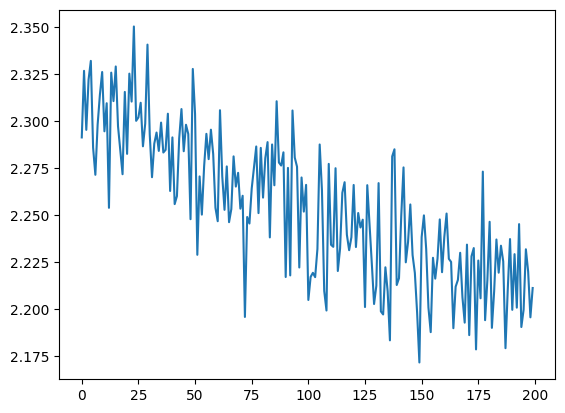

In [12]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)

Проверка сети
====================

Для выборки мы даем сети букву и спрашиваем, какая следующая буква,
вводим ее в качестве следующей буквы и повторяем до тех пор, пока не появится токен EOS.

- Создание тензоров для категории ввода, начальной буквы и пустого скрытого
состояния
- Создайте строку `output_name` с начальной буквой
- До максимальной выходной длины,

   - Передать текущую букву в в сеть
   - Получить следующую букву с самого высокого выходного значения и следующее скрытое состояние
   - Если буква EOS, остановитесь здесь
   - Если обычная буква, добавьте в `output_name` и продолжайте

- Верните окончательное имя

.. Примечание::
   Вместо того, чтобы указывать ему начальную букву, другой
стратегией было бы включить в обучение токен `start of string`
и заставить сеть выбрать свою собственную начальную букву.



In [13]:
max_length = 20

# Выборка на основе category и начальной буквы start_letter
def sample(category, start_letter='A'):
    with torch.no_grad():  # нет необходимости настройки весов при генерации букв
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# Генерация множества выборок из одной категории и множества начальных букв
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print("category: " + category + ", start_letter: " + start_letter + ", name: " + sample(category, start_letter))
    print()

samples('Russian', 'RUS')
samples('German', 'GER')
samples('Spanish', 'SPA')
samples('Chinese', 'CHI')

category: Russian, start_letter: R, name: Rokalovek
category: Russian, start_letter: U, name: Uakher
category: Russian, start_letter: S, name: Shakin

category: German, start_letter: G, name: Gres
category: German, start_letter: E, name: Eres
category: German, start_letter: R, name: Rosher

category: Spanish, start_letter: S, name: Seriera
category: Spanish, start_letter: P, name: Paner
category: Spanish, start_letter: A, name: Alara

category: Chinese, start_letter: C, name: Chan
category: Chinese, start_letter: H, name: Han
category: Chinese, start_letter: I, name: Iun



Упражнения
=========

- Попробуйте использовать другой набор данных category -> line, например:

   - Вымышленный сериал -> Имя персонажа
   - Часть речи -> Слово
   - Страна -> Город

- Используйте маркер "начало предложения", чтобы выборка могла быть выполнена без выбора начальной буквы
- Получите лучшие результаты с помощью сети большего размера и / или лучшей формы

   - Попробуйте nn.LSTM и nn.GRU
   - - Объедините несколько таких запусков в сеть более высокого уровня



# Задание 1.
Добавьте в модель слой nn.GRU() оцените качество модели.

In [10]:
import torch
import torch.nn as nn
import time

class RNN1(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN1, self).__init__()
        self.hidden_size = hidden_size

        self.gru = nn.GRU(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        output, hidden = self.gru(input_combined.unsqueeze(0), hidden.unsqueeze(0))
        output = self.i2o(output.squeeze(0))
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden.squeeze(0)

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    
rnn1 = RNN1(n_letters, 128, n_letters)

In [11]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

In [12]:
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) 
    return torch.LongTensor(letter_indexes)

In [13]:
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

In [14]:
criterion = nn.NLLLoss()

learning_rate = 0.001

def train1(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn1.initHidden()

    rnn1.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn1(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn1.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

In [22]:
n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train1(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 35s (5000 5%) 2.5207
1m 14s (10000 10%) 2.5399
1m 53s (15000 15%) 1.3346
2m 23s (20000 20%) 3.0568
2m 50s (25000 25%) 2.8148
3m 16s (30000 30%) 2.7856
3m 43s (35000 35%) 1.5890
4m 7s (40000 40%) 2.0106
4m 36s (45000 45%) 2.9202
5m 11s (50000 50%) 1.5231
5m 50s (55000 55%) 1.9072
6m 29s (60000 60%) 1.9703
7m 8s (65000 65%) 2.0791
7m 47s (70000 70%) 2.2100
8m 26s (75000 75%) 2.4471
9m 5s (80000 80%) 1.7510
9m 44s (85000 85%) 3.2098
10m 23s (90000 90%) 3.5708
11m 2s (95000 95%) 2.6647
11m 43s (100000 100%) 2.7112


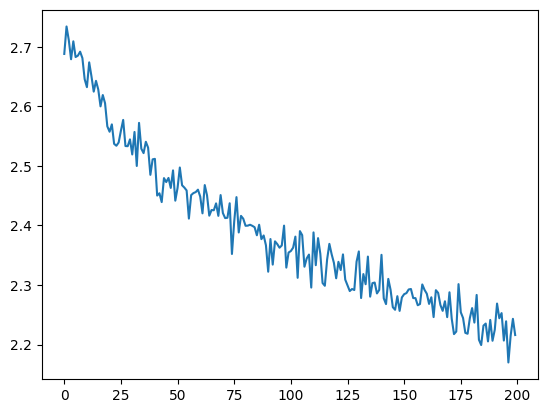

In [23]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)

In [24]:
max_length = 20

def sample(category, start_letter='A'):
    with torch.no_grad(): 
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print("category: " + category + ", start_letter: " + start_letter + ", name: " + sample(category, start_letter))
    print()
        
samples('Russian', 'RUS')
samples('German', 'GER')
samples('Spanish', 'SPA')
samples('Chinese', 'CHI')

category: Russian, start_letter: R, name: RoF-zoF-zzzzF-FoF-zzz
category: Russian, start_letter: U, name: UzzzzF-FoF-zzF-FoF-zP
category: Russian, start_letter: S, name: SoF-oF-zzzPePeePeePee

category: German, start_letter: G, name: Gzzzzzzzzzzzzzzzzzzzz
category: German, start_letter: E, name: EzzzzzzzzSoFDoFDoMzzz
category: German, start_letter: R, name: RSMzzzzzzzSoFDoFDoFDo

category: Spanish, start_letter: S, name: SPIzzPPPeDzzzzzPPPeDz
category: Spanish, start_letter: P, name: PezzzzPPPeDzzzzzzzzzz
category: Spanish, start_letter: A, name: AePPeDzzzzzzzPPPeDzzb

category: Chinese, start_letter: C, name: CQzMMMMMMMMMMMMMMMMMM
category: Chinese, start_letter: H, name: HQMBMSMMMMMSMMMMMMMMS
category: Chinese, start_letter: I, name: IQaSMMMMMMMSMMMSMMMMM

